# Reverse Engineering Transformers

This is from an amazing blog post by https://blog.nelhage.com/post/transformers-for-software-engineers/

It outlines the implementation of a GPT-style Transformer. 

Note that this is just **one** way to learn transformers! I've learned these concepts using a various kind of analogies and terms. 

In this same folder there is the Transformer implementation in RUST. 

In Transformers, each token gets represented as a vector --- a list of numbers. These numbers change as the token passes through **each layer** of the model. 

The **state**/**residual stream** is the current version of a vector at a given layer. 

## Key Assumptions in this paper 

There is **no consideration for Positional Encodings** in this implementation. The attention operation sees ALL EARLIER POSITIONS and does not determine which positions are clsoer to the current token. 

In the "Attention is All You Need Transformer", there are a bunch of sine and cosine waves of varying frequencies after the embedding. 

Bias terms are also not considered. 

## Autoregressive Language Modeling

In a nutshell:

Takes in a sequence of text (context) and outputs sequence of "logits" the same length as the context. 

The logits represent the model's prediction for the next token. At each position, there is one logit value per entry in vocabulary by taking a **softmax over the logit vector**. This provides a probability distribution over tokens. 

The logits for the final input position thus correspond to predictions for the **next token** following the context. By sampling from this distribution you can generate a continuation of context. This method is how Transformers can be used to generate text. 

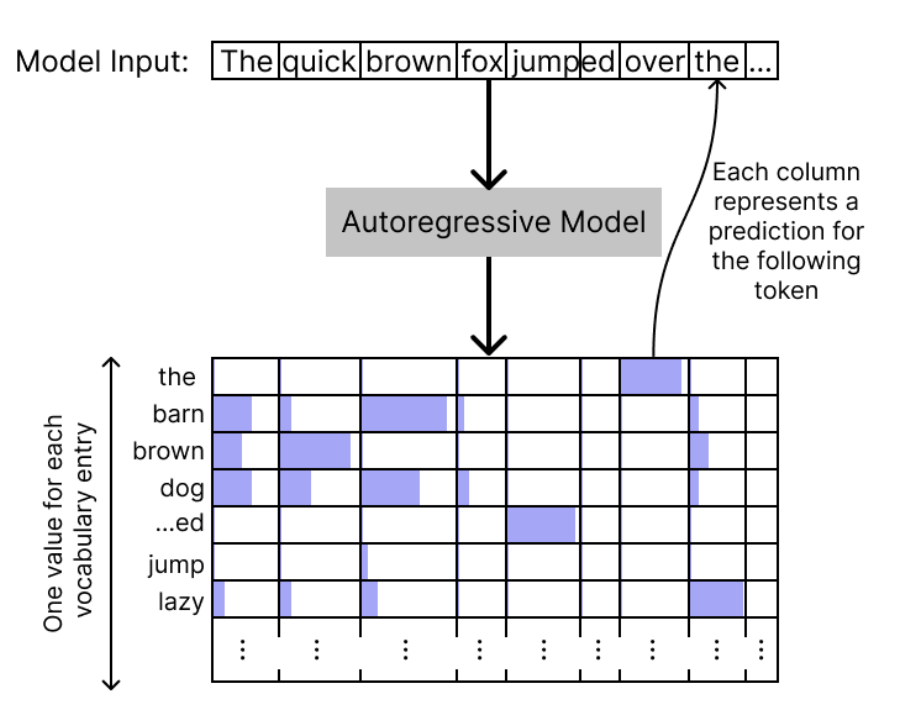

## The residual stream "state vector" 

Each layer takes in the previous "hidden state" of the model -- one state per each token position. This does some computation, then udpates that state to produce the following state. 

The author considers the state an "opaque data structure". 

The state exposes two main operations: 
- **Query**  - We provide a "query" vector and take a dot product with that vector to produce a single floating-point value. 

It's like "Hey state, how much of this feature do we currently have"? This is just a dot product 

- **Update** - We can update it by providing an "update" vector which will be added to the state vector. 

"Here's new information, add it to the state". 

It's just $ state = state + update $

So to summarize, the state/residual stream is just a vector that holds all the model's **current knowledge** about a token. 

We ultimately end up with vectors of states, one per token position. These are just 2d tensors. 

## The Layers: Embedding

A transformer starts with an embedding layer, then followed by some number of **residual blocks**, and finally an unembedding layer. 

## The Layers: The (un)embedding

The purpose of embedding and (un)embedding is to convert between tokens to and from the internal state. 

This unembedding is responsible for turning the state back into logits. 

Typically it's represented as a matrix of shape D_MODEL X N_VOCAB. It is applied to a state via a matrix multiplication. 

## The Residual Blocks 

Each residual block consists of an attention layer followed by an MLP layer. 



## Attention 

Transformers use "multi-headed" attention; each attention layer consists of a number of different attention heads operating a smaller subspace of size D_HEAD. 

Each head is made up of **four different linear functions**. 


## "Multi-headed" Attention

This means each attention layer consists of **different attention heads** operating a smaller subspace of size **D_HEAD**. Each head consists of four "linear functions". 

The author abstracts the Q/K/V/O Weight matrices as generic functions.

Attention is also the only oepration that mixes information **between** token positions. 

## MLP Layers 

This is usually written as parametrized by two matrices, sometimes called W_in and W_out/W_up/W_down. 

Each neuron 
- Queries the state using its input vector to produce a single scalar. 
- Applies a nonlinear function to that scalar (Typically a ReLU or GeLU)
- Then it scales its output vector by that scalar. 

Each neuron acts completley independently. The operation of each indivdual neuron is just 

Dot Product --> ReLU --> Multiply-Accumulate (MatMul)